In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%%bash
rm extMesh/system/blockMeshDict

# 0. Input values

Just vary the parameters inside this section and then click Run All

## 0.0 Case parameters

In [3]:
target_yplus = 10
U = 10
mu = 0.00001789
rho = 1.2

## 0.1 Basic parameters

In [4]:
chord = 1          #chord of the airfoil
percChord = 0.25   #percentage of the chord in which the block cut is made
Vspace = 3*chord   #vertical space above and below the airfoil
wake = 7*chord     #horizontal space after the trailing edge
minZ = 0.0         #minimum z-coordinate value
maxZ = 0.1         #maximum z-coordinate value
NACAtype = '0012'  #NACA 4 digit airfoil

## 0.2 Grid configuration

In [5]:
inflowXcells = 100   #number of cells ahead the airfoil 
middleXcells = 20    #number of cells over the airfoil 
outflowXcells = 100  #number of cells downstream the airfoil

yCells = 50          #number of cells above and below the airfoil

zCells = 1           #number of cells in the z-direction

## 0.3 Airfoil chord configuration

In [6]:
noPoints = inflowXcells + middleXcells   #number of points of the airfoil (and therefore upstream and over the airfoil)
                                                 
percentage = np.array([0.1, 0.15, 0.4, 0.35])    #percentage distribution of points in the chord 
                                                 #the first two must add to percChord
divisions = np.array([0.2, 0.2, 0.25, 0.35])     #allocation of the noPoints divisions over the chord
expansionR = np.array([1, 1, 1, 1])           #expansion ratio of each one of the divisions

## 0.4 Grading of Y direction 

In [7]:
expansionRatioYdir = 1.321
NoLayers = 15

# 1. Function declaration

In [8]:
def NACA4(s, chord):

    #definition of the NACA profile as XXXX
    NACA = s
    c = chord #chord line

    #NACA XXXX = m p (pt)
    m = int(int(NACA)/1e3)/1e2 #maximum camber
    p = int((int(NACA)-m*1e5)/1e2)/1e1 #location of maximum camber
    pt = int((int(NACA)-m*1e5-p*1e3)) #percentage of thickness with respect to the chord

    #mean camber line definition
    if p != 0:
        x = np.append(np.linspace(0,p/100*c,500)[:-1],np.linspace(p/100*c,c,250))
        x_pc = x<(p*c) #masked array to create the piece-wise function

        yc1 = ((c*m)/(p**2))*(2*p*(x/c)-(x/c)**2)
        yc2 = ((c*m)/((1-p)**2))*((1-2*p)+2*p*(x/c)-(x/c)**2)

        yc = np.zeros(np.shape(x))

        for i in range(np.shape(x)[0]):
            if x_pc[i] == True:
                yc[i] = yc1[i]
            else:
                yc[i] = yc2[i]

        #mean camber line derivative
        dyc1dx = (2*m)/(p**2)*(p-(x/c))
        dyc2dx = (2*m)/((1-p)**2)*(p-(x/c))

        dycdx = np.zeros(np.shape(x))

        for i in range(np.shape(x)[0]):
            if x_pc[i] == True:
                dycdx[i] = dyc1dx[i]
            else:
                dycdx[i] = dyc2dx[i]

        theta = np.arctan(dycdx)

    else:
        #symmetric airfoil camber line
        x = np.linspace(0,c,750)
        yc = np.zeros(np.shape(x))

    #thickness
    if p != 0:
        yt = 5*pt/100*(0.2969*np.sqrt(x/c)-0.1260*(x/c)-0.3516*(x/c)**2+0.2843*(x/c)**3-0.1036*(x/c)**4)
        xu = x - yt*np.sin(theta)
        xl = x + yt*np.sin(theta)
        yu = yc + yt*np.cos(theta)
        yl = yc - yt*np.cos(theta)

        return xu, xl, yu, yl
        
    else:
        yt = 5*pt/100*(0.2969*np.sqrt(x/c)-0.1260*(x/c)-0.3516*(x/c)**2+0.2843*(x/c)**3-0.1036*(x/c)**4)

        return x, x, yt, -yt

In [9]:
def simple_grading(N, expRatio, L):
    delta = np.zeros(N) #size of each cell array
    nodes = np.zeros(N+1) #position of the nodes

    kVal = expRatio**((1)/(N-1)) 
    k = np.zeros(N) #increment of each cell

    for i in range(N):
        k[i] = kVal**(i) 

    deltaS = L/np.sum(k)  #first cell size 

    delta = deltaS*k #size of each cell
    
    for i in range(N):
        nodes[i+1] = nodes[i] + delta[i]
        
    return nodes

In [10]:
def multi_grading(perc, cells, eps, N, L): 
    
    #some initial shape and value comprobations
    if np.sum(perc) != 1:
        print('Bad percentage array input')
        return

    if np.sum(cells) != 1:
        print('Bad cell array input')
        return
    
    if np.shape(perc)[0] != np.shape(cells)[0] or np.shape(perc)[0] != np.shape(eps)[0] or np.shape(cells)[0] != np.shape(eps)[0]:
        print('Non equal vector definition')
        return
        
    segmentN = (N*cells) #cells per segment
    restCells = np.modf(segmentN)[0] #in case there are decimal values
    segmentN = np.trunc(segmentN) #integer value of the cells

    i = np.sum(restCells) #distributor of the 'decimal' parts of the cells
    while i > 0:
        segmentN[np.argmax(restCells)] = segmentN[np.argmax(restCells)] + int(i)
        restCells[np.argmax(restCells)] = 0
        i -= 1
   
    segmentL = (L*perc) #length per segment

    nodes = np.zeros(N+1) #number of nodes
        
    for i in range(np.shape(perc)[0]):
        nodesTemp = simple_grading(int(segmentN[i]), eps[i], segmentL[i])
        for j in range(np.shape(nodesTemp)[0]):
            if i == 0:
                nodes[j] = nodesTemp[j]
            else:
                nodes[int(np.cumsum(segmentN)[i-1]) + j] = nodesTemp[j] + nodes[int(np.cumsum(segmentN)[i-1])]

    return nodes

In [11]:
def grading_plot(x): #nodes should be imported

    y = 0.5*np.ones(np.shape(x)[0])
    
    fig, ax = plt.subplots(figsize=(20, 1), dpi=100)
        
    ax.set_xlim(-x[1]*0.5,1.1*x[-1])
    ax.set_ylim(0,1)
    ax.axis('off')
    ax.plot([x[0],x[-1]],[y[0],y[-1]],'k')
    ax.scatter(x,y,c='k')

In [12]:
def airfoilTrueX(newX, xu, yu, xl, yl):
    yuAxis = np.interp(newX, xu, yu)
    ylAxis = np.interp(newX, xl, yl)
    return yuAxis, ylAxis

In [13]:
def BLcalculator(target_yplus, U, L, mu, rho, flow, expansionRatio, NoLayers, length, totalCells, grid_dir):
    Re = (rho*U*L)/(mu)

    if flow == 'e':
        cf = 0.058*Re**(-0.2)
    else:
        cf = 0.079*Re**(-0.25)

    dy1 = target_yplus*mu/(rho*np.sqrt(0.5*cf*U**2))
    
    layerSize = dy1*np.ones(NoLayers)

    for i in range (1, NoLayers):
        layerSize[i] = layerSize[i-1]*expansionRatio

    yCoord = np.cumsum(layerSize)
    
    BL_length = yCoord[-1]
    bm_expRatio = expansionRatio**(NoLayers-1)
    
    if grid_dir == 't':
        perc = np.array([BL_length/length, 1-BL_length/length])
        cells = np.array([NoLayers/totalCells, (totalCells-NoLayers)/totalCells])
        exp = np.array([bm_expRatio, 1])
    else:
        perc = np.array([1-BL_length/length, BL_length/length])
        cells = np.array([(totalCells-NoLayers)/totalCells, NoLayers/totalCells])
        exp = np.array([1, bm_expRatio])
    
    return perc, cells, exp

# 2. Point calculations

### 2.1. Spline points

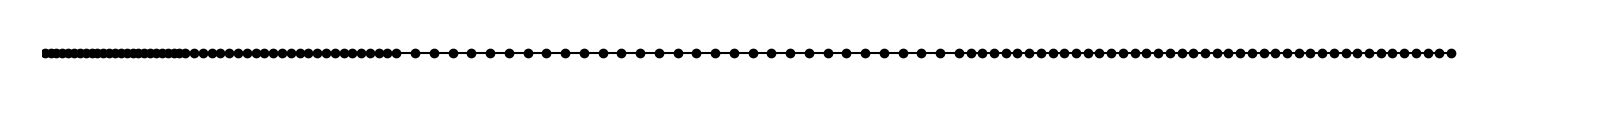

In [14]:
#xAxis = multi_grading(percentage, divisions, expansionR, noPoints, chord)

#while (np.abs(xAxis-percChord*chord)).argmin() != inflowXcells:
#    inflowXcells = (np.abs(xAxis-percChord*chord)).argmin()
#    xAxis = multi_grading(percentage, divisions, expansionR, noPoints, chord)
#    print(inflowXcells)

    
xAxis = multi_grading(percentage, divisions, expansionR, noPoints, chord)
    
xu, xl, yu, yl = NACA4(NACAtype, chord)

yuAxis, ylAxis = airfoilTrueX(xAxis, xu, yu, xl, yl)

if any(np.isin(np.cumsum(percentage), percChord*np.ones(len(percentage)))) == False:
    print('Bad percentage array declaration')
    
if percentage[0]+percentage[1] != percChord:
    print('Bad percentage array declaration')
    
grading_plot(xAxis)

### 2.2. Vertice points

In [15]:
zero = np.array([-Vspace, 0.0])
one = np.array([1-chord, 0.0])
two = np.array([1-chord+xAxis[(np.abs(xAxis-percChord*chord)).argmin()], yuAxis[(np.abs(xAxis-percChord*chord)).argmin()]])
three = np.array([1-chord+xAxis[(np.abs(xAxis-percChord*chord)).argmin()], Vspace])
four = np.array([1.0, Vspace])
five = np.array([1.0, 0.0])
six = np.array([wake, Vspace])
seven = np.array([wake, 0.0])
eight = np.array([wake, -Vspace])
nine = np.array([1.0, -Vspace])
ten = np.array([1-chord+xAxis[(np.abs(xAxis-percChord*chord)).argmin()], -Vspace])
eleven = np.array([1-chord+xAxis[(np.abs(xAxis-percChord*chord)).argmin()], ylAxis[(np.abs(xAxis-percChord*chord)).argmin()]])

### 2.3. Expansion ratios

In [16]:
percYdir, cellsYdir, expYdir = BLcalculator(target_yplus, U, chord, mu, rho, 'e', expansionRatioYdir, NoLayers, Vspace, yCells, 't')

### 2.4. Blocks definition

In [17]:
class blocksClass:
     def __init__(self, nodes, cellNo, grading):
        self.nodes = nodes
        self.cells = cellNo
        self.grading = grading

In [18]:
nodes = np.array([[1,2,3,0,13,14,15,12],      #block0
                 [2,5,4,3,14,17,16,15],       #block1
                 [5,7,6,4,17,19,18,16],       #block2
                 [13,23,22,12,1,11,10,0],     #block3
                 [23,17,21,22,11,5,9,10],     #block4
                 [17,19,20,21,5,7,8,9]])      #block5

cellsNo = np.array([[inflowXcells, yCells, zCells],     #block0
                  [middleXcells, yCells, zCells],       #block1
                  [outflowXcells, yCells, zCells],      #block2
                  [inflowXcells, yCells, zCells],       #block3
                  [middleXcells, yCells, zCells],       #block4
                  [outflowXcells, yCells, zCells]])     #block5

grading = np.array([[[[percentage[0], divisions[0], expansionR[0]],[percentage[1], divisions[1], expansionR[1]]], [[percYdir[0], cellsYdir[0], expYdir[0]],[percYdir[1], cellsYdir[1], expYdir[1]]], 1],     #block0
                   [[[percentage[2], divisions[2], expansionR[2]],[percentage[3], divisions[3], expansionR[3]]], [[percYdir[0], cellsYdir[0], expYdir[0]],[percYdir[1], cellsYdir[1], expYdir[1]]], 1],      #block1
                   [1, [[percYdir[0], cellsYdir[0], expYdir[0]],[percYdir[1], cellsYdir[1], expYdir[1]]], 1],                                                                                                #block2
                   [[[percentage[0], divisions[0], expansionR[0]],[percentage[1], divisions[1], expansionR[1]]], [[percYdir[0], cellsYdir[0], expYdir[0]],[percYdir[1], cellsYdir[1], expYdir[1]]], 1],      #block3
                   [[[percentage[2], divisions[2], expansionR[2]],[percentage[3], divisions[3], expansionR[3]]], [[percYdir[0], cellsYdir[0], expYdir[0]],[percYdir[1], cellsYdir[1], expYdir[1]]], 1],      #block4
                   [1, [[percYdir[0], cellsYdir[0], expYdir[0]],[percYdir[1], cellsYdir[1], expYdir[1]]], 1]])                                                                                               #block5

blocks = blocksClass(nodes, cellsNo, grading)

### 2.5. Arc edge

In [19]:
arc = np.array([Vspace*np.cos(np.deg2rad(45)), Vspace*np.sin(np.deg2rad(45))])

### 2.6. Boundaries 

In [20]:
class boundaryClass:
     def __init__(self, name, Btype, faceNo, faces):
        self.name = name
        self.type = Btype
        self.faceNo = faceNo
        self.faces = faces

In [21]:
boundName = np.array(['inlet', 'outlet', 'airfoil', 'frontAndBack'])
boundType = np.array(['patch', 'patch', 'patch', 'empty'])
boundFaceNo = np.array([4, 4, 4, 12])
boundFaces = np.array([[[3, 15, 12, 0], [0, 12, 22, 10], [10, 22, 21, 9], [9, 21, 20, 8]],
                      [[15, 3, 4, 16], [16, 4, 6, 18], [18, 6, 7, 19], [19, 7, 8, 20]], 
                      [[2, 14, 17, 5], [5, 17, 23, 11], [13, 1, 11, 23], [14, 2, 1, 13]],
                      [[15, 14, 13, 12], [15, 16, 17, 14], [16, 18, 19, 17], [17, 19, 20, 21], [23, 17, 21, 22], [12, 13, 23, 22],
                       [2, 3, 0, 1], [4, 3, 2, 5], [6, 4, 7, 5], [1, 0, 10, 11], [11, 10, 9, 5], [5, 9, 8, 7]]])

boundary = boundaryClass(boundName, boundType, boundFaceNo, boundFaces)

# 3. Header

In [22]:
with open('./extMesh/system/blockMeshDict', 'a') as bMD:
    bMD.write('/*--------------------------------*- C++ -*----------------------------------*\ \n')
    bMD.write('| =========                 |                                                 | \n')
    bMD.write('| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           | \n')
    bMD.write('|  \\    /   O peration     | Version:  5                                     | \n')
    bMD.write('|   \\  /    A nd           | Web:      www.OpenFOAM.org                      | \n')
    bMD.write('|    \\/     M anipulation  |                                                 | \n')
    bMD.write('\*---------------------------------------------------------------------------*/ \n')
    bMD.write('\n')
    bMD.write('FoamFile \n')
    bMD.write('{ \n')
    bMD.write('    version     2.0; \n')
    bMD.write('    format      ascii; \n')
    bMD.write('    class       dictionary; \n')
    bMD.write('    object      blockMeshDict;; \n')
    bMD.write('} \n')
    bMD.write('// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * // \n')
    bMD.write('\n')
    bMD.write('convertToMeters 1; \n')
    bMD.write('\n')

# 4. Vertices

In [23]:
with open('./extMesh/system/blockMeshDict', "a") as bMD:
    bMD.write('vertices \n')
    bMD.write('( \n')
    bMD.write('    (%.8f %.8f %.8f) \n' %(zero[0], zero[1], minZ))         #0
    bMD.write('    (%.8f %.8f %.8f) \n' %(one[0], one[1], minZ))           #1
    bMD.write('    (%.8f %.8f %.8f) \n' %(two[0], two[1], minZ))           #2
    bMD.write('    (%.8f %.8f %.8f) \n' %(three[0], three[1], minZ))       #3
    bMD.write('    (%.8f %.8f %.8f) \n' %(four[0], four[1], minZ))         #4
    bMD.write('    (%.8f %.8f %.8f) \n' %(five[0], five[1], minZ))         #5
    bMD.write('    (%.8f %.8f %.8f) \n' %(six[0], six[1], minZ))           #6
    bMD.write('    (%.8f %.8f %.8f) \n' %(seven[0], seven[1], minZ))       #7
    bMD.write('    (%.8f %.8f %.8f) \n' %(eight[0], eight[1], minZ))       #8
    bMD.write('    (%.8f %.8f %.8f) \n' %(nine[0], nine[1], minZ))         #9
    bMD.write('    (%.8f %.8f %.8f) \n' %(ten[0], ten[1], minZ))           #10
    bMD.write('    (%.8f %.8f %.8f) \n' %(eleven[0], eleven[1], minZ))     #11
    bMD.write('    (%.8f %.8f %.8f) \n' %(zero[0], zero[1], maxZ))         #12
    bMD.write('    (%.8f %.8f %.8f) \n' %(one[0], one[1], maxZ))           #13
    bMD.write('    (%.8f %.8f %.8f) \n' %(two[0], two[1], maxZ))           #14
    bMD.write('    (%.8f %.8f %.8f) \n' %(three[0], three[1], maxZ))       #15
    bMD.write('    (%.8f %.8f %.8f) \n' %(four[0], four[1], maxZ))         #16
    bMD.write('    (%.8f %.8f %.8f) \n' %(five[0], five[1], maxZ))         #17
    bMD.write('    (%.8f %.8f %.8f) \n' %(six[0], six[1], maxZ))           #18
    bMD.write('    (%.8f %.8f %.8f) \n' %(seven[0], seven[1], maxZ))       #19
    bMD.write('    (%.8f %.8f %.8f) \n' %(eight[0], eight[1], maxZ))       #20
    bMD.write('    (%.8f %.8f %.8f) \n' %(nine[0], nine[1], maxZ))         #21
    bMD.write('    (%.8f %.8f %.8f) \n' %(ten[0], ten[1], maxZ))           #28
    bMD.write('    (%.8f %.8f %.8f) \n' %(eleven[0], eleven[1], maxZ))     #23
    bMD.write('); \n')
    bMD.write('\n')

# 5. Blocks

In [24]:
with open('./extMesh/system/blockMeshDict', "a") as bMD:
    bMD.write('blocks \n')
    bMD.write('( \n')
    for i in range(len(blocks.nodes)):
        bMD.write('    hex (%i %i %i %i %i %i %i %i) (%i %i %i) simpleGrading\n' %(blocks.nodes[i][0], blocks.nodes[i][1], 
                                                                                   blocks.nodes[i][2], blocks.nodes[i][3], 
                                                                                   blocks.nodes[i][4], blocks.nodes[i][5], 
                                                                                   blocks.nodes[i][6], blocks.nodes[i][7], 
                                                                                   blocks.cells[i][0], blocks.cells[i][1],
                                                                                   blocks.cells[i][2]))
        bMD.write('    ( \n') 
        for j in range(len(blocks.grading[i])):
            if isinstance(blocks.grading[i][j], int) == False:
                bMD.write('     ( \n')    
                for k in range(len(blocks.grading[i][j])):
                    bMD.write('     (%.3f %.3f %.3f) \n' %(blocks.grading[i][j][k][0], blocks.grading[i][j][k][1], blocks.grading[i][j][k][2]))
                bMD.write('     ) \n')
            else:
                bMD.write('    %.3f \n' %(blocks.grading[i][j]))
        bMD.write('    ) \n')
    bMD.write('); \n')
    bMD.write('\n')

# 6. Edges

In [25]:
with open('./extMesh/system/blockMeshDict', "a") as bMD:
    bMD.write('edges \n')
    bMD.write('( \n')
    bMD.write('    arc 0 3   (%.8f %.8f %.8f) \n' %(-arc[0], arc[1], minZ))
    bMD.write('    arc 12 15 (%.8f %.8f %.8f) \n' %(-arc[0], arc[1], maxZ))
    bMD.write('    arc 0 10  (%.8f %.8f %.8f) \n' %(-arc[0], -arc[1], minZ))    
    bMD.write('    arc 12 22 (%.8f %.8f %.8f) \n' %(-arc[0], -arc[1], maxZ))

    bMD.write('    spline 1 11 ( \n')
    for i in range((np.abs(xAxis-percChord*chord)).argmin()):
        bMD.write('        (%.8f %.8f %.8f) \n' %(xAxis[i], ylAxis[i], minZ))
    bMD.write('        ) \n')

    bMD.write('    spline 1 2 ( \n')
    for i in range((np.abs(xAxis-percChord*chord)).argmin()):
        bMD.write('        (%.8f %.8f %.8f) \n' %(xAxis[i], yuAxis[i], minZ))
    bMD.write('        ) \n')
    
    bMD.write('    spline 11 5 ( \n')
    for i in range((np.abs(xAxis-percChord*chord)).argmin(), len(xAxis)):
        bMD.write('        (%.8f %.8f %.8f) \n' %(xAxis[i], ylAxis[i], minZ))
    bMD.write('        ) \n')
    
    bMD.write('    spline 2 5 ( \n')
    for i in range((np.abs(xAxis-percChord*chord)).argmin(), len(xAxis)):
        bMD.write('        (%.8f %.8f %.8f) \n' %(xAxis[i], yuAxis[i], minZ))
    bMD.write('        ) \n')

    bMD.write('    spline 13 23 ( \n')
    for i in range((np.abs(xAxis-percChord*chord)).argmin()):
        bMD.write('        (%.8f %.8f %.8f) \n' %(xAxis[i], ylAxis[i], maxZ))
    bMD.write('        ) \n')

    bMD.write('    spline 13 14 ( \n')
    for i in range((np.abs(xAxis-percChord*chord)).argmin()):
        bMD.write('        (%.8f %.8f %.8f) \n' %(xAxis[i], yuAxis[i], maxZ))
    bMD.write('        ) \n')
    
    bMD.write('    spline 23 17 ( \n')
    for i in range((np.abs(xAxis-percChord*chord)).argmin(), len(xAxis)):
        bMD.write('        (%.8f %.8f %.8f) \n' %(xAxis[i], ylAxis[i], maxZ))
    bMD.write('        ) \n')
    
    bMD.write('    spline 14 17 ( \n')
    for i in range((np.abs(xAxis-percChord*chord)).argmin(), len(xAxis)):
        bMD.write('        (%.8f %.8f %.8f) \n' %(xAxis[i], yuAxis[i], maxZ))
    bMD.write('        ) \n')  
    
    bMD.write('); \n')
    bMD.write('\n')


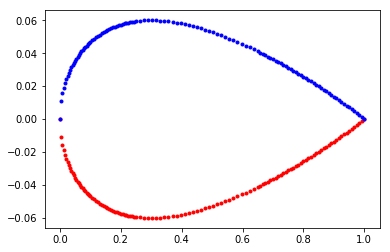

In [26]:
plt.plot(xAxis, ylAxis, '.r')
plt.plot(xAxis, yuAxis, '.b')

# 7. Boundary

In [27]:
with open('./extMesh/system/blockMeshDict', "a") as bMD:
    bMD.write('boundary \n')
    bMD.write('( \n')
    for i in range(len(boundary.name)):
        bMD.write('    %s \n' %boundary.name[i])
        bMD.write('    { \n')
        bMD.write('        type %s; \n' %boundary.type[i])
        bMD.write('        faces \n')
        bMD.write('        ( \n')
        for j in range(boundary.faceNo[i]):
            bMD.write('            (%i %i %i %i) \n' %(boundary.faces[i][j][0], boundary.faces[i][j][1], boundary.faces[i][j][2], boundary.faces[i][j][3]))
        bMD.write('        ); \n')
        bMD.write('    } \n')
    bMD.write('); \n')

# 8. blockMesh and paraFoam

In [28]:
%%bash
cd extMesh/
blockMesh
nohup paraFoam

Process is interrupted.
